## Assignment 11: Geographic visualization with CartoDB

In this assignment, the second-to-last of the semester, we will venture outside of the Python ecosystem to create interactive maps with CartoDB, a web-based geospatial data storage, analysis, and visualization platform.  You'll be making an interactive map of burglaries in Fort Worth for the first half of 2015, drawn from the same dataset you worked with in Assignment 8.  You'll explore methods for visualizing large amounts of point data, as well as create interactive maps that show trends in burglaries over time.  

In this instance, you are going to upload a bulk CSV download that I've prepared for you from the City's open data catalog.  The data as currently constituted are not quite ready for use in CartoDB, so we're going to clean it up a bit in `pandas` first.  

As we discussed in class, CartoDB accepts data in many formats, such as CSV, GeoJSON, and zipped shapefile; [see here for the full listing](http://docs.cartodb.com/cartodb-editor/datasets/#supported-file-formats).   In this instance, our data are in CSV format.  Let's read the data into `pandas` and have a look.  

In [1]:
import pandas as pd

data = "http://personal.tcu.edu/kylewalker/data/burglaries2015.csv"

df = pd.read_csv(data)

df.head()

,Case_No_Offense,Case_No,Reported_Date,Nature_Of_Call,From_Date,Offense,Offense_Desc,BLOCK_ADDRESS,City,State,Beat,Division,CouncilDistrict,Attempt_Complete,Location_Type,LocationTypeDescription,intTotal,Location_1
0,150000165-220,150000165,01/01/2015 12:00:00 AM,BURG BUILD,01/01/2015 12:00:00 AM,220,Burglary,5100 BLOCK WICHITA ST,Fort Worth,TX,C44,C,8,C,24,Speciality store,0,"(32.686681044559926, -97.280407627736238)"
1,150000187-220,150000187,01/01/2015 12:00:00 AM,BURG RES,01/01/2015 12:00:00 AM,220,Burglary,2700 BLOCK QUINN ST,Fort Worth,TX,C42,C,5,C,20,"Residence, home",0,NaN
2,150000190-220,150000190,01/01/2015 12:00:00 AM,BURG COMM,01/01/2015 12:00:00 AM,220,Burglary,6500 BLOCK MEADOWBROOK DR,Fort Worth,TX,E24,E,5,C,17,Liquor store,0,"(32.746011096597293, -97.218819442381601)"
3,150000210-220,150000210,01/01/2015 12:00:00 AM,BURG RES,01/01/2015 12:00:00 AM,220,Burglary,3000 BLOCK MC KINLEY AVE,Fort Worth,TX,N31,N,2,C,20,"Residence, home",0,"(32.799674538970372, -97.369010160096721)"
4,150000251-220,150000251,01/01/2015 12:00:00 AM,BURG RES,01/01/2015 12:00:00 AM,220,Burglary,3800 BLOCK AVE G,Fort Worth,TX,C41,C,8,C,20,"Residence, home",0,"(32.729725211613555, -97.269106791461653)"


Scroll to the right-hand side of your data frame to view the `Location_1` column.  You'll notice that it is formatted as latitude/longitude coordinate pairs, separated by a comma and enclosed in parentheses.  Additionally, some of the latitude/longitude values are missing.  

In [15]:
null_rows = pd.isnull(df.Location_1)

null_rows.value_counts()

False    2520
True      122
dtype: int64

It looks like 122 rows in our dataset are missing latitude and longitude information.  In a regular data analysis workflow, you'd want to do some investigation of these missing values, and ultimately see if there is any systematic bias there.  As our focus here is mapping in CartoDB, however, let's forge ahead.  

To map CSV data, CartoDB requires that one column contain the longitude coordinates, and one column contain the latitude coordinates.  As such, we'll need to get rid of the parentheses in the column, then split the column into two columns, and finally add those columns back to our data frame.  Study the code below to examine what it does: 

In [18]:
# Loop through the characters in the string we want to replace, and replace them in turn
for char in ['(', ')']: 
    df['Location_1'] = df.Location_1.str.replace(char, '')
    
# Split our `Location_1` column at the comma with the `.split()` method; 
# the `expand = True` argument returns a new data frame
locs = df.Location_1.str.split(',', expand = True)

locs.columns = ['latitude', 'longitude']

# Add these new columns to our existing data frame with the 
# `pd.concat` method, to which we pass a list of data frames; 
# specifying `axis = 1` makes sure that we combine columns, not
# rows.  
df2 = pd.concat([df, locs], axis = 1)

df2.head()

,Case_No_Offense,Case_No,Reported_Date,Nature_Of_Call,From_Date,Offense,Offense_Desc,BLOCK_ADDRESS,City,State,Beat,Division,CouncilDistrict,Attempt_Complete,Location_Type,LocationTypeDescription,intTotal,Location_1,latitude,longitude
0,150000165-220,150000165,01/01/2015 12:00:00 AM,BURG BUILD,01/01/2015 12:00:00 AM,220,Burglary,5100 BLOCK WICHITA ST,Fort Worth,TX,C44,C,8,C,24,Speciality store,0,"32.686681044559926, -97.280407627736238",32.686681044559926,-97.280407627736238
1,150000187-220,150000187,01/01/2015 12:00:00 AM,BURG RES,01/01/2015 12:00:00 AM,220,Burglary,2700 BLOCK QUINN ST,Fort Worth,TX,C42,C,5,C,20,"Residence, home",0,NaN,NaN,None
2,150000190-220,150000190,01/01/2015 12:00:00 AM,BURG COMM,01/01/2015 12:00:00 AM,220,Burglary,6500 BLOCK MEADOWBROOK DR,Fort Worth,TX,E24,E,5,C,17,Liquor store,0,"32.746011096597293, -97.218819442381601",32.746011096597293,-97.218819442381601
3,150000210-220,150000210,01/01/2015 12:00:00 AM,BURG RES,01/01/2015 12:00:00 AM,220,Burglary,3000 BLOCK MC KINLEY AVE,Fort Worth,TX,N31,N,2,C,20,"Residence, home",0,"32.799674538970372, -97.369010160096721",32.799674538970372,-97.369010160096721
4,150000251-220,150000251,01/01/2015 12:00:00 AM,BURG RES,01/01/2015 12:00:00 AM,220,Burglary,3800 BLOCK AVE G,Fort Worth,TX,C41,C,8,C,20,"Residence, home",0,"32.729725211613555, -97.269106791461653",32.729725211613555,-97.269106791461653


Success!  We can now write our location-aware data frame to a CSV, for use in CartoDB.  

In [19]:
df2.to_csv('burg2015.csv', index = False)

When you run this cell, `pandas` will write a CSV file named `burg2015.csv` in your Notebook's directory.  Go find it and make sure you know where it is; let's now head over to CartoDB at https://cartodb.com/.  

## Working with CartoDB

Visit the CartoDB website at the link above.  If you didn't create an account in class, follow the instructions below; if you've already created a CartoDB account, you can skip ahead.  

On the CartoDB website, look for the "Sign Up" button; it should be displayed prominently in the center of the screen, and is also found on the top right.  Click there.  You'll be taken to the "Sign up for CartoDB" page; you'll have the option to log in with your Google account if you already have one, or enter a username, email, and password.  CartoDB will then take a few moments to set up your account.  Your free account gives you 250MB of data storage; paid plans offer more storage and more features.  

Once your account has been created, you'll be taken to your CartoDB dashboard.  Add your burglaries CSV to CartoDB by dragging and dropping the file on your dashboard; alternatively you can click the "New Dataset" button if you prefer.  After you've dropped your CSV into your CartoDB account, CartoDB will take a few moments to process your data file.  If your dataset has uploaded correctly, you should be taken to your "Data View", which shows your dataset in tabular form.  

![data view](http://personal.tcu.edu/kylewalker/img/data_view.PNG)

Notice the column named `the_geom`.  This is the _geometry_ column in your table, which describes the location of your data.  As we've appropriately named our latitude and longitude columns in `pandas`, CartoDB has recognized those columns and created a geometry column from our CSV accordingly.  In some cases, CartoDB will not be able to figure this out automatically; in this instance, you may need to specify the geometry columns yourself by clicking __Edit &#8680; Georeference__, and following the directions provided.

Now that your data are uploaded, you probably want to take a look at it!  Change the tab at the top of the screen from Data View to __Map View__.  You should see a map of Fort Worth, with the locations of burglaries from the first six months of 2016 displayed on the screen, as in the image below.  

![map_view](http://personal.tcu.edu/kylewalker/img/map_view.PNG)

CartoDB has a feature that will create "interesting maps" for you that appears in the lower-left hand corner of the screen; we'll explore some of these ourselves through the menus.  Before we do this, however, we'll want to appropriately specify our date column so that we can visualize trends over time.  Click "Data View" from the top of the screen again, and find the `from_date` column, which is currently formatted as a string.  This column represents the date of the offense.  Click the column header to change the column type to `date`, as in the GIF below.  

<img src="http://personal.tcu.edu/kylewalker/img/to_date.gif" style="width: 600px">

Now, click __Visualize__ in the upper-right corner of your screen.  You'll be asked if you want to create a map, and you will tell CartoDB that this is OK.  Now, click Map View again; you'll have options to both style your data and format your map.  

Take a few moments to explore your map view.  On the top, you have options available to add map elements, preview your map, or export as a static image.  In the bottom-left corner, you can change your map's basemap, selecting from a number of pre-made styles, or even your own custom basemap (those of you taking Urban GIS with me next semester will learn how to make one!).  You can also change your map's options; CartoDB doesn't default to enabling scroll wheel zoom, so I like to turn that on.  

Importantly, however, you have options to manipulate the appearance of your data on the right-hand side of the screen.  The SQL pane allows you to interact with and manipulate your data using Structured Query Language, the standard syntax for querying databases.  One of the brilliant things about CartoDB is that once you've uploaded your data to CartoDB's cloud, it converts your data into a SQL-enabled PostGIS database, the most popular open-source spatial database.  We're not going to worry about this for this assignment, but for the GIS students among you - this means that you can do numerous GIS operations with your data in CartoDB.  If you want to learn more, check out the tutorial here: http://academy.cartodb.com/courses/04-sql-postgis.html.  

The option that is most important for us in this assignment is the Wizards pane, denoted by the paintbrush icon.  Click it and take a look.  CartoDB has defaulted to the "simple" style, in which every dot is the default orange.  This may make sense for some applications, but in areas of high point density it can make things appear cluttered when zoomed out.  As such, CartoDB provides several built-in methods for styling point data.  As you go through the list below, select the options in turn in CartoDB and see how they work.   

* __Cluster__: when zoomed out, overlapping points will be denoted by a larger circle labeled with the number of points it represents; 
* __Choropleth__: represents quantitative variation in a selected column by color on the map; 
* __Category__: represents qualitative variation in a selected column by color; 
* __Bubble__: quantitative variation in a selected column is represented by point size on the map; 
* __Torque__: an animated time series visualization.  Spend some time modifying the options for this one.  If you've followed the instructions above correctly to convert the date column, the "Time Column" should default to `from_date`.  This date will then be represented by a time slider in the lower-left of your map.  You can choose to make your Torque map "cumulative," which means that points from the past will stay on the screen throughout the period, or turn this off to only show points from a selected period at a time.  I won't go through all the other options - but try modifying them to see how your map changes.  
* __Heatmap__: These types of maps are more appropriately called _kernel density maps_; you may remember the term "kernel density" from your work with `seaborn` earlier in the semester.  Kernel density maps are analogous here as they leverage a similar algorithm but apply it to geographic coordinates on a map.  Try experimenting with this style as well; heatmaps can also be animated over time by choosing the available option.  
* __Torque cat__: like Torque, but can style your dots by a categorical column; 
* __Intensity__: uses color blending to show areas of greater/less concentration; 
* __Density__: "bins" your data into either hexagons or rectangles and shades the shapes accordingly.  Something is off with this method at the moment - I've been having trouble getting it to work properly.  

Other options give you greater control over interactivity and the appearance of your map.  For visualization methods that show each individual point, you can select the __Infowindow__ option to modify the pop-up that appears when the map viewer clicks a point.  This pop-up can contain information from any of the fields in your table.   The __CSS__ tab allows you to style your data manually using CartoCSS, a CSS-like syntax for styling map data.  The __Legends__ tab gives you control over the appearance of your legend (when applicable), and the __Filters__ tab gives you an interactive way to subset your data, without having to write SQL.  

Choose a method of visualization and map style that you feel is appropriate for the data - animated or not, either way is fine.  Have some fun making your map!  Add map elements, change your basemap, and customize your styling as appropriate.  When you are finished, click the __Publish__ button in the upper-right corner.  

![publish](http://personal.tcu.edu/kylewalker/img/publish.PNG)

You can share a direct link to your CartoDB map for sharing, you can get IFrame code for embedding in a website (or a Jupyter Notebook!), or you can get the path to the visualization for use in CartoDB.js, CartoDB's JavaScript library for creating more sophisticated web applications.  

One other incredibly cool thing about CartoDB: it exposes all public datasets via its SQL API for dynamic programmatic access.  To find out how to make a call to the API, visit your CartoDB profile at https://{yournamehere}.cartodb.com/me.  My profile, for example, is https://kwalkertcu.cartodb.com/me.  Click the link to view your (or my) datasets, and choose one; then, look for the "API Call" link at the bottom of the page.  Click it, and you'll get a link you can use to access your data as a JSON API!  For example, check out what we can do here: 

In [27]:
api_call = 'https://kwalkertcu.cartodb.com:443/api/v2/sql?q=select latitude, longitude from public.burg2015_1'

cleaned_call = api_call.replace(' ', '%20') + '&format=csv' # we ask it to return CSV; easier for pandas

burglaries = pd.read_csv(cleaned_call)

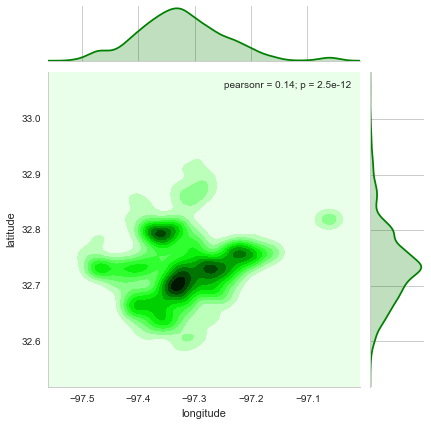

In [30]:
import seaborn as sns
sns.set(style = 'whitegrid')
sns.set_context('notebook')
%matplotlib inline

sns.jointplot(data = burglaries, x = 'longitude', y = 'latitude', kind = 'kde', color = 'green')

# You can kind of see the shape of the city on the plot!

One could envision an interactive report in the Jupyter Notebook that includes both maps and charts; for example, the IFrame code available from CartoDB can also be embedded right in the Jupyter Notebook, and in turn sit alongside `seaborn` or Plotly plots.  

## For submission

All you need to do to get credit for this assignment is submit a link to your map to me!  The map can't be the default, however - it needs to be clear that you've spend some time modifying it to get full credit.  The easiest way to submit the map to me is to grab the "Get the link" link from the "Publish" menu, then submit the link to me via the eCollege dropbox.  However, I'll also accept by email as that's how we've been doing things this semester.  